In [1]:
# Genre Prediction
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras import layers,Model
from tensorflow.keras.applications import ResNet50

In [2]:
imageDirectory = 'posters/'
imdb_df = pd.read_csv('finalIMDB1.csv')
imdb_df.rename(columns={'Unnamed: 0':'IMDb_ID'},inplace=True)
imdb_df.tail()

,IMDb_ID,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,IMDb_ID
2495,10094,387892,http://www.imdb.com/title/tt387892,Brodeuses (2004),7.0,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,tt10095
2496,10096,52654,http://www.imdb.com/title/tt52654,The Bridge (1959),7.8,Drama|War,https://images-na.ssl-images-amazon.com/images...,tt10097
2497,10097,263467,http://www.imdb.com/title/tt263467,In the Time of the Butterflies (2001),6.8,Crime|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,tt10098
2498,10098,40740,http://www.imdb.com/title/tt40740,Road House (1948),7.3,Action|Drama|Film-Noir,https://images-na.ssl-images-amazon.com/images...,tt10099
2499,10099,93664,http://www.imdb.com/title/tt93664,Oci ciornie (1987),7.6,Comedy|Romance|Drama,https://images-na.ssl-images-amazon.com/images...,tt10100


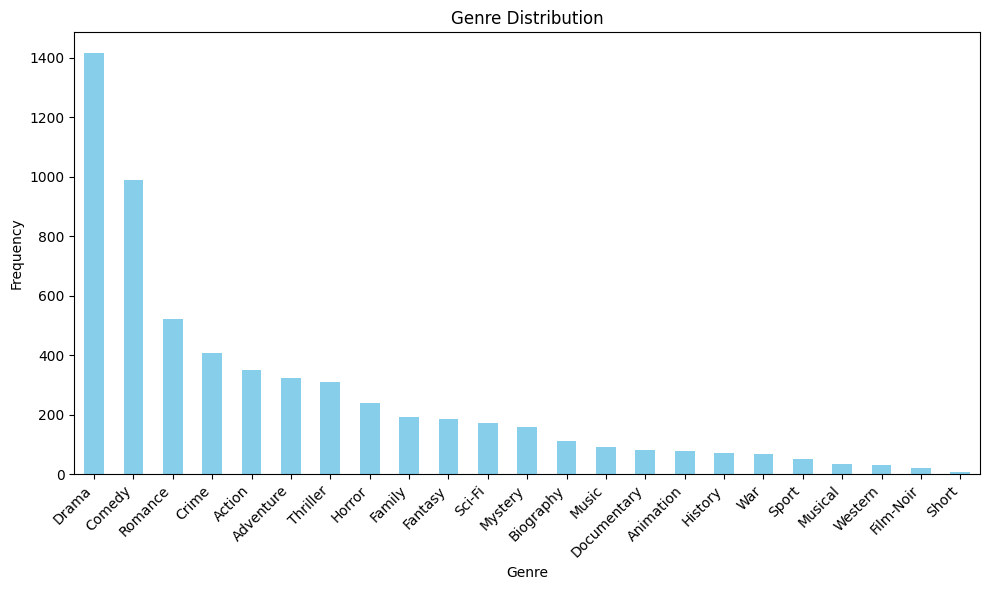

In [3]:
genre_counts = imdb_df['Genre'].str.strip().str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
imdb_df['Genre'].dtypes
imdb_df.count()

IMDb_ID       2500
imdbId        2500
Imdb Link     2500
Title         2500
IMDB Score    2500
Genre         2498
Poster        2500
IMDb_ID       2500
dtype: int64

In [5]:
imdb_df['Genre'] = imdb_df['Genre'].fillna('')
imdb_df['Genre'] = imdb_df['Genre'].astype(str)


In [6]:
top_genres = imdb_df['Genre'].value_counts().head(6).index.tolist()
imdb_df['Main Genre'] = imdb_df['Genre'].apply(lambda x: x if x in top_genres else 'Other')
print(top_genres)
print(imdb_df['Main Genre'].head())

['Drama', 'Comedy|Drama', 'Comedy|Drama|Romance', 'Drama|Romance', 'Comedy', 'Comedy|Romance']
0                   Other
1                   Other
2          Comedy|Romance
3    Comedy|Drama|Romance
4                   Other
Name: Main Genre, dtype: object


In [7]:

multiclassBinarizer = MultiLabelBinarizer()
# labels = multiclassBinarizer.fit_transform(imdb_df['Genre'].str.split('|'))
# imageIds = imdb_df['IMDb_ID']
# num_classes = len(multiclassBinarizer.classes_)
# print(num_classes)
# print(multiclassBinarizer.classes_)
# print(labels[:5])

encodedLabels = multiclassBinarizer.fit_transform(imdb_df['Main Genre'].apply(lambda x: [x] ))
num_classes = len(multiclassBinarizer.classes_)
print(encodedLabels[:5])
print(num_classes)
print(multiclassBinarizer.classes_)


[[0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]]
7
['Comedy' 'Comedy|Drama' 'Comedy|Drama|Romance' 'Comedy|Romance' 'Drama'
 'Drama|Romance' 'Other']


In [8]:
image_dir = 'posters/'

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]

input_images = []
for image_path in image_paths:
    img = load_img(image_path,target_size=(350,350,3))
    img_array = img_to_array(img)
    input_images.append(img_array)

input_images = np.array(input_images) / 255.0

print("Data Type:", input_images.dtype)
print("Data Shape:", input_images.shape)

Data Type: float32
Data Shape: (2500, 350, 350, 3)


In [9]:
X_train,X_test,y_train,y_test = train_test_split(input_images, encodedLabels, test_size=0.1)
print(encodedLabels.shape)


(2500, 7)


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
new_model = tf.keras.Sequential([
    layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=X_train[0].shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='sigmoid')
])

new_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 348, 348, 16)      448       
                                                                 
 batch_normalization_4 (Bat  (None, 348, 348, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 174, 174, 16)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 174, 174, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 172, 172, 32)      4640      
                                                                 
 batch_normalization_5 (Bat  (None, 172, 172, 32)     

In [15]:
# history = model.fit(
#     train_datagen.flow(X_train, y_train, batch_size=32),
#     epochs=5,
#     validation_data=(X_test, y_test)
# )

history= new_model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10


71/71 [==============================] - 165s 2s/step - loss: 0.7542 - accuracy: 0.2147 - val_loss: 1.1131 - val_accuracy: 0.7280
Epoch 2/10
71/71 [==============================] - 149s 2s/step - loss: 0.5135 - accuracy: 0.4756 - val_loss: 4.7079 - val_accuracy: 0.7280
Epoch 3/10
71/71 [==============================] - 146s 2s/step - loss: 0.3263 - accuracy: 0.6578 - val_loss: 7.4553 - val_accuracy: 0.7240
Epoch 4/10
71/71 [==============================] - 146s 2s/step - loss: 0.2678 - accuracy: 0.6924 - val_loss: 4.4792 - val_accuracy: 0.6640
Epoch 5/10
71/71 [==============================] - 147s 2s/step - loss: 0.2423 - accuracy: 0.6924 - val_loss: 1.3392 - val_accuracy: 0.6560
Epoch 6/10
71/71 [==============================] - 146s 2s/step - loss: 0.2321 - accuracy: 0.7009 - val_loss: 0.5570 - val_accuracy: 0.6640
Epoch 7/10
71/71 [==============================] - 146s 2s/step - loss: 0.2025 - accuracy: 0.7276 - val_loss: 2.7717 - val_accuracy: 0.4520
Epoch 8/10


In [6]:
# Training based on Pre-trained model

image_dir = 'posters/'

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]

input_images = []
for image_path in image_paths:
    img = load_img(image_path,target_size=(224,224,3))
    img_array = img_to_array(img)
    input_images.append(img_array)

input_images = np.array(input_images) / 255.0

print("Data Type:", input_images.dtype)
print("Data Shape:", input_images.shape)

Data Type: float32
Data Shape: (2500, 224, 224, 3)


In [13]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

classificationLayers = layers.Conv2D(128,kernel_size=(3,3),activation='relu')(base_model.output)
classificationLayers = layers.MaxPooling2D((2,2))(classificationLayers)
classificationLayers = layers.Flatten()(classificationLayers)
classificationLayers = layers.Dense(128, activation='relu')(classificationLayers)
output = layers.Dense(7, activation='sigmoid')(classificationLayers)

pretrainedModel = Model(inputs=base_model.input, outputs=output)

pretrainedModel.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = pretrainedModel.fit(input_images,encodedLabels,epochs=10,batch_size=32,validation_split=0.1)

Epoch 1/10
71/71 [==============================] - 260s 4s/step - loss: 0.3823 - accuracy: 0.6880 - val_loss: 0.2954 - val_accuracy: 0.6680
Epoch 2/10
71/71 [==============================] - 254s 4s/step - loss: 0.2722 - accuracy: 0.7013 - val_loss: 0.2752 - val_accuracy: 0.6680
Epoch 3/10
71/71 [==============================] - 253s 4s/step - loss: 0.2533 - accuracy: 0.7022 - val_loss: 0.3008 - val_accuracy: 0.6680
Epoch 4/10
71/71 [==============================] - 251s 4s/step - loss: 0.2498 - accuracy: 0.7040 - val_loss: 0.2886 - val_accuracy: 0.6680
Epoch 5/10
71/71 [==============================] - 253s 4s/step - loss: 0.2455 - accuracy: 0.7044 - val_loss: 0.2790 - val_accuracy: 0.6640
Epoch 6/10
71/71 [==============================] - 253s 4s/step - loss: 0.2389 - accuracy: 0.7076 - val_loss: 0.2930 - val_accuracy: 0.6640
Epoch 7/10
71/71 [==============================] - 253s 4s/step - loss: 0.2375 - accuracy: 0.7107 - val_loss: 0.2966 - val_accuracy: 0.6680
Epoch 8/10
71